# Collaboration and Competition

---

The environment for this project is [Tennis](https://github.com/udacity/deep-reinforcement-learning/tree/master/p3_collab-compet) from Unity, and it's provided in the `setup` folder. We'll implement a slight variation of [MADDPG](https://arxiv.org/pdf/1706.02275.pdf) where two agents share the same actor and critic networks, to allow for a self-play mechanism.

![final](imgs/gif.gif "final")

> The model used to generate this gif is `final.pth`, which was trained for 2000 episodes using `main.py`.

## 1. Prepare dependencies and environment

Take a look at README.md before executing this notebook and make sure that the kernel is set to **p3_collab_compet**.

In [1]:
!pip -q install ./setup

import sys
import platform

import numpy as np
from numpy_ringbuffer import RingBuffer
import copy
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

from setup import unityagents
from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Unity environments contain **brains**, our interfaces for controlling agents. We'll be conrtolling the first (default) brain in the environment. It's also useful to keep information such as `state_size`, `action_size` and `num_agents`.

In [2]:
env = None
system = platform.system()
if system == 'Linux':
    env = UnityEnvironment(file_name="setup/Tennis_Linux/Tennis.x86_64")
elif system == 'Darwin':
    env = UnityEnvironment(file_name="setup/Tennis.app")
elif system == 'Windows':
    env = UnityEnvironment(file_name="setup/Tennis_Windows_x86_64/Tennis.exe")
else:
    print('Cannot find environment for this system.')

# use the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 2. Experience replay

Just like in DQN, one of the key features of DDPG and MADDPG is that experiences are stored as tuples and learning is delayed and performed in sampled batches. We'll use the **uniform** variation of the replay buffer here, meaning that all stored tuples have the same chance of being selected for replay. The buffer has fixed `capacity` and will delete older tuples as newer ones arrive.

Every tuple is stored as `(s, a, r, ns, d)` where:

- `s` is the state at the beginning of the timestep
- `a` is the action that was taken
- `r` is the reward obtained in the next timestep
- `ns` is the state at the next timestep (we'll refer to this as $s'$ as well)
- `d` is a boolean value that determines if the episode ended

Note that **a single tuple stores the values for all agents at timestep `t`**, so the shape is in the form of `[num_agents, x]`.

When sampling a batch of `n` tuples, we'll obtain a single tuple `([s], [a], [r], [ns], [d])` where:
- `[s]`, `[a]`, `[r]`, `[ns]`, `[d]` are **torch tensors** with size `[n, num_agents, x]`.

In [3]:
class UniformReplayBuffer():

    def __init__(self, capacity):
        self.capacity = capacity
        self.reset()
    
    def reset(self):
        self.buff = RingBuffer(capacity=self.capacity, dtype=object)
    
    def sample(self, n, replace=True):
        samples = np.random.choice(np.array(self.buff), n, replace)
        
        s = torch.FloatTensor([sample[0] for sample in samples]).to(device)
        a = torch.FloatTensor([sample[1] for sample in samples]).to(device)
        r = torch.FloatTensor([sample[2] for sample in samples]).to(device)
        ns = torch.FloatTensor([sample[3] for sample in samples]).to(device)
        d = torch.FloatTensor([sample[4] for sample in samples]).to(device)
        
        return s, a, r, ns, d
    
    def add(self, observation):
        s, a, r, ns, d = observation
        self.buff.append((s, a, r, ns, d))
    
    def size(self):
        return len(self.buff)

## 3. Noise

The noise used for exploration comes from an Ornstein-Uhlenbeck process.

In [4]:
class OUNoise:
    def __init__(self, size, mu=0, theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## 4. Actor

DDPG is an **actor-critic method** and as such requires two models, one to represent the policy (the actor) and one to represent the value function (the critic). These models could be represented with just one network that has two distinct final layers – this is particularly useful when there are convolutional layers at the beginning of the network, as it helps extrapolating important information from the environment – but we don't need to do that, since the input consists of only 24 values per agent. We'll instead implement two separate models.

The `Actor` class is straightforward and consists of only fully connected layers:

- `state_size` $\to 256$ followed by `relu` activations
- $256 \to 128$ and `relu`
- $128 \to a$, that is $128 \to$ `action_size` with `tanh`.

`Actor` outputs a deterministic vector $a$, which has two elements whose values are between $-1$ and $1$. If the environment didn't pose restrictions on the action values, we wouldn't be using any activation function here.

In this implementation, **the actor is always used in a batch**. Indeed, because of self-play, the two agents share the same network, so the input is made of two vectors for a total size of `[num_agents, state_size]` and, similarly, the output contains two $a$ vectors that can be seen as a matrix of size `[num_agents, action_size]`. Note that processing data in a batch is not required but can help speed up calculations.

In [5]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers=[256, 128]):
        super(Actor, self).__init__()

        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])

        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the actor will output the action a that maximizes Q(s, a)
        self.output_layer = nn.Linear(hidden_layers[-1], action_size)
    
    def forward(self, state):
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        out = self.output_layer(state)
        return F.tanh(out)

## 5. Critic for Multi-Agent DDPG with self-play

The `Critic` class is also made of only fully connected layers:

- `state_size * 2` $\to 512$ followed by `relu` activations
- $512 \ +$ `action_size * 2` $\to 256$ and `relu`
- $256 \to Q(s, a)$ that is $256 \to 1$ and no activation.

`Critic` is very similar to the `DQN` class, except it does not process $Q(s, a)$ for all possible actions $a$ at the same time. The reason is simple: **actions are continuous** here so we can't do that! Instead, `Critic` receives $s$ and one action $a$ as inputs, and outputs a single value $Q(s, a)$ – which is more in line with the definition of the $Q$ function, anyway.

This `Critic` receives two states and two actions at the same time (`state_size * 2` and `action_size * 2`, respectively in the first and second layers). In fact, MADDPG describes the idea of **centralized training and decentralized execution**. That is, actors only receive their local observations, whereas critics receive all observations and actions, but are only used while training. The idea is that each agent will be trained knowing what the others do, but will still be able to act independently at the end of the training process, which is ideal for scenarios where **competition and/or cooperation are required, but communication between agents is limited**.

If we indicate the input for a `Critic` as $I = (s_1, a_1, s_2, a_2)$, where $s_1$ is the state received by agent $1$ and $a_1$ is its action, we can represent a **standard MADDPG** architecture as having two critics $C_1$ and $C_2$ that both receive the **same input** $I$ but train for two **different outputs**. In other words, $C_1(I)$ is trained to resemble the true $Q_1((s_1, s_2, a_2), a_1)$, where $(s_1, s_2, a_2)$ are considered fixed as they come from the environment, and similarly $C_2(I)$ should resemble the true $Q_2((s_1, s_2, a_1), a_2)$.

In our case, however, we only have one `Critic` $C$, so for each tuple of experience we would have two different values $Q_1$ and $Q_2$ to train it with. To solve this, we can create two different inputs $I_1 = (s_1, a_1, s_2, a_2)$ and $I_2 = (s_2, a_2, s_1, a_1)$ by essentially **flipping the states and actions**, and then performing gradient descent on the error from $C(I_1)$ to $Q_1$, and from $C(I_2)$ to $Q_2$. This way, the `Critic` will consider the first pair of values as coming from **its own agent**, and the second pair as coming from **the other agent**, when in reality the two agents simply "take turns" in being one or the other. Also, note that the two turns can be computed in a batch, just as we did earlier with the `Actor`.

In [6]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, num_agents, hidden_layers=[512, 256]):
        super(Critic, self).__init__()

        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size * num_agents, hidden_layers[0])])
        
        # this makes room to concatenate the given action in the second layer
        edited_hidden_layers = [hl for hl in hidden_layers]
        edited_hidden_layers[0] = hidden_layers[0] + action_size * num_agents

        # prepare the rest of the hidden layers
        A = edited_hidden_layers[:-1]
        B = edited_hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the critic will output an estimate of Q(s, a)
        self.output_layer = nn.Linear(edited_hidden_layers[-1], 1)

    def forward(self, state, action):        
        
        # the input to this network is managed in two steps:
        # - first step only considers the states
        state = self.hidden_layers[0](state)
        state = F.relu(state)

        # - second step adds the actions by concatenating
        #   them with the first hidden layer's output
        state = torch.cat((state, action), dim=2)

        for layer in self.hidden_layers[1:]:
            state = layer(state)
            state = F.relu(state)
        return self.output_layer(state)

## 5. MADDPG with self-play

To create an instance of MADDPG, the following are required:

- `alpha` $\in [0, 1]$, the learning rate to apply to gradient steps to `critic` and `actor`
- `eps`, `eps_delta` and `min_eps` $\in \mathbb{R}$, to add Ornstein-Uhlenbeck noise to the actions, if `learning = False` no noise will be added; the noise will be decremented from `eps` to `min_eps` linerly, with steps of size `eps_delta` taken at the end of every episode
- `gamma` $\in [0, 1]$, the weight of the estimates for future returns calculated by `target_action` and `target_critic`
- `tau` $\in [0, 1]$, to perform soft updates of `target_action` and `target_critic` (if set to $1$ directly copies local versions into the targets)
- `update_every` the number of steps to wait before updating all four networks
- `batch_size` the number of samples from the `replay_buffer` used to perform one update step

Default values are provided in the `init` function and are also reported in the next markdown cell.

Of all the functions in the MADDPG class, only `act`, `store` and `new_episode` should normally be called from the outside: 
- `act`, based on a state tensor `s` and on `eps`, choose an action. If the agent has `learning = False` no noise will be added
- `store`, receive a tuple to put in the `replay_buffer`. This counts as a step towards the networks' updates, and in fact calls `learn()` automatically when needed
- `new_episode` will adjust the noise at the beginning of a new episode

Additionally, an agent can be `reset()`.

### 5.1 The `learn()` function

Training the `Critic` is easy and pretty much identical to `DQN`: we estimate the TD target $r + Q_{target}(s', a')$ using a target network – in particular, $a'$ is chosen by a **target actor** and evaluated by a **target critic**, which means that there is a total of four networks at play – and then calculate the mean squared error from $Q_{local}(s, a)$. (_See section `1` in function `learn()`_.)

However, how do we train the `Actor`? The output of the actor is a deterministic vector $a \in \mathbb{R}^k$, so we can't maximize or minimize log probabilities as we would do in A2C or PPO. We can, however, leverage the `Critic`'s knowledge of the environment. Remember that our goal is to maximize expected return, which is exactly what `Critic` estimates.

So we can use our estimate of $Q(s, a)$ to compute the gradient required to maximize it. We shouldn't, however, update the `Critic` with this information. Instead, we can backpropagate it up to its inputs, $s$ and $a$. Now, we can't directly control $s$, so we'll ignore that, but we are in control of $a$! The action vector $a$ is a torch.tensor that comes from our other network, `Actor`, and as such it can still propagate gradient information with autograd. So, instead of stopping the backpropagation process here, we can keep going and get the gradient for our `Actor` as well. As already mentioned, at this point we won't be updating the `Critic`'s weights, but only the `Actor`'s. (_See section `2` in function `learn()`_.)

The paper for DDPG also describes the soft update strategy (that we already used in the first project for `DQN` updates). Essentially, instead of performing a "hard copy" of the local networks' parameters into the target networks' ones, we interpolate between them and assign the result as the new targets. Usually this is done with an interpolation factor $\tau$ that is set to retain most of the target networks data. In this case, `tau = 0.001`. (_See section `3` in function `learn()`_.)

Note that the functions `flip`, `partial_detach`, and `preprocess` are useful for processing data in a batch and are explained in the next markdown cell.

In [7]:
class MADDPG:
    
    # -- initialization -- #

    def __init__(self, state_size, action_size, num_agents, replay_buffer,
                 update_every=1, batch_size=1024, alpha=0.0003, gamma=0.99, tau=0.001,
                 eps=3, min_eps=0.5, delta_eps=0.002, learning=True):
        self.state_size, self.action_size, self.num_agents = state_size, action_size, num_agents
        self.update_every, self.batch_size = update_every, batch_size
        self.replay_buffer = replay_buffer
        self.alpha, self.gamma, self.tau = alpha, gamma, tau
        self.original_eps, self.min_eps, self.delta_eps = eps, min_eps, delta_eps
        self.noise = OUNoise(size=(self.num_agents, self.action_size))
        self.learning = learning
        self.reset()

    def reset(self):        

        self.actor, self.target_actor = Actor(self.state_size, self.action_size).to(device), \
                                        Actor(self.state_size, self.action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.alpha)
        with torch.no_grad():
            for local, target in zip(self.actor.parameters(), self.target_actor.parameters()):
                target.copy_(local)

        self.critic, self.target_critic = Critic(self.state_size, self.action_size, self.num_agents).to(device), \
                                          Critic(self.state_size, self.action_size, self.num_agents).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha)
        with torch.no_grad():
            for local, target in zip(self.critic.parameters(), self.target_critic.parameters()):
                target.copy_(local)

        self.replay_buffer.reset()
        self.noise.reset()
        self.update_i = 0
        self.eps = self.original_eps

    # -- initialization -- #
    
    def act(self, state):
        state = torch.FloatTensor(state).to(device)

        # predict the action a that will maximize Q(s, a)
        action = self.actor(state)
        action = np.array(action.detach())

        # if the agent is learning, we also add some noise
        # to the network's output to favor exploration
        if self.learning:
            action += self.eps * self.noise.sample()
        
        # the environment only allows actions to be in the range of [-1, 1]
        return np.clip(action, -1, 1)
    
    def store(self, s, a, r, ns, d):
        # store a new experience
        self.replay_buffer.add((s, a, r, ns, d))

        if self.update_i == 0 and self.replay_buffer.size() >= self.batch_size:
            # after you've stored enough new experiences, update the networks
            self.learn()

        # keep track of how many new experiences we get
        self.update_i = (self.update_i + 1) % self.update_every

    def new_episode(self):
        # reset and decrease the intensity of the noise in the next episode
        self.noise.reset()
        self.eps = max(self.eps - self.delta_eps, self.min_eps)

    def flip(self, x):
        return torch.cat((x[:, 1, :].unsqueeze(1), x[:, 0, :].unsqueeze(1)), dim=1)

    def partial_detach(self, x):
        return torch.cat((x[:, 0, :].unsqueeze(1), x[:, 1, :].unsqueeze(1).detach()), dim=1)
    
    def preprocess(self, x, detach=False):
        x_flip = self.flip(x)
        if detach:
            x = self.partial_detach(x)
            x_flip = self.partial_detach(x_flip)
        return torch.cat((x, x_flip), dim=2)

    def learn(self):
        # note that this is called automatically by the agent

        # sample tuples of experiences from memory (each of these variables is a torch tensor)
        s, a, r, ns, d = self.replay_buffer.sample(self.batch_size)
        

        # Section 1: we use the target actor and target critic to estimate
        #  - the predicted best action na in the next state ns
        na = self.target_actor(ns)

        na_final = self.preprocess(na)
        ns_final = self.preprocess(ns)

        #  - the predicted value of Q(ns, na)
        target_values = self.target_critic(ns_final, na_final)
        #  - and finally the TD target
        targets = r.unsqueeze(2) + (self.gamma * target_values * (1 - d.unsqueeze(2)))

        s_final = self.preprocess(s)
        a_final = self.preprocess(a)

        # We also compute Q(s, a), but using the local critic this time
        # Note that we're not using the local actor here, since a comes from the replay buffer
        expected_values = self.critic(s_final, a_final)
        
        # Having the TD target and Q(s, a), we can now calculate the mean squared error
        critic_loss = torch.mean((targets.detach() - expected_values) ** 2)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()


        # Section 2: we use our local actor and local critic to estimate
        #  - the predicted best action expected_a for the current state s
        expected_a = self.actor(s)

        expected_a_final = self.preprocess(expected_a, detach=True)

        #  - the predicted value of Q(s, expected_a)
        policy_values = self.critic(s_final, expected_a_final)

        #  - and, finally, we ask to maximize this last predicted value
        #    note: torch performs gradient descent, so we need a
        #    negative sign to indicate that we want gradient ascent
        actor_loss = -torch.mean(policy_values)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()


        # Section 3: we perform a soft update of the two target networks by 
        # interpolating between the current parameters and the new ones
        with torch.no_grad():
            for local, target in zip(self.critic.parameters(), self.target_critic.parameters()):
                target.copy_(target + self.tau * (local - target))
            for local, target in zip(self.actor.parameters(), self.target_actor.parameters()):
                target.copy_(target + self.tau * (local - target))

### 5.2 Handling data in a batch

As noted earlier, data is processed in batches – but it's a bit more complicated than that. There is a "first level" of batch which is determined by the number of experiences sampled `batch_size = 1024`, but there is also "another level" of batch that is determined by `num_agents = 2`. So, for instance, `s` and `ns` will be of size `[1024, 2, 24]`, though the actor expects a tensor of size `[24]`. Roughly speaking, through the magic of pytorch this will be considered as `1024 * 2` independent calls, so the ouptut of `self.actor(s)` will have the shape `[1024, 2, 2]`.

But since the critic needs to receive the observations and actions from all agents, it gets a bit trickier. Let's explain with an example using the vector of states `s`. To keep things simple, imagine we're only sampling one memory from the replay buffer, so we can ignore the first dimension of `1024`. We can split `s` in two vectors of size `[24]` denoted by `A` and `B`, each containing local observations for one of the two agents. Therefore, `s` can be described as a matrix `[A, B]`. As the name implies, `flip` provides the matrix `[B, A]`.

The most important function here however is `preprocess`, which provides a matrix `[AB, BA]`. Our critic will consider this as a batch of two independent experiences, where `AB` is a vector of size `[48]` that indicates that the agent we're evaluating received `A`, while "the other agent" received `B` (and viceversa for `BA`).

Similarly, when the actor is learning from the **actions** `AB`, the gradient should only be computed for `A`, since `B` is the action performed by "the other agent" and we can't control it from this point of view. Instead, we'll be able to change `B` when we process `BA`, and in that case `A` will be fixed. This is the reason why we need `partial_detach`, so that `B` in `AB` and `A` in `BA` won't use autograd.

## 6. Training an agent

Choosing the right hyperparameters is crucial in reinforcement learning, but even more so in the multi agent setting. I have tried a number of combinations of hyperparameters and eventually settled on these ones, although training is still not perfect and sometimes does not converge to a good solution. It might be possible to find a better configuration, but running the learning code with these parameters a couple of times usually yields a good solution.

- `eps=3`, `delta_eps=0.002`, `min_eps=0.5`,
- `gamma=0.99`
- `alpha=0.0003`
- `tau=0.001`
- `update_every=1`
- `batch_size=1024`
- `capacity=1e6` (of the replay buffer)

Note that the following code is borrowed from my previous project for `DQN` where I had to run a number of experiments, each with a different configuration. There's no need for `agents` to be an array here, but I decided to keep it because it might still be useful in the future. The same goes for some values and choices in the next two functions.

In [8]:
agents = [('MADDPG-SP', MADDPG(state_size, action_size, num_agents, UniformReplayBuffer(1_000_000)))]

What we define now is a function that connects our agents and environment. Recall that we'll be using the default `brain_name` to interact with the environment. The agents are allowed to store observations and learn from them (calls to `learn()` happen automatically at every step).

In [9]:
def execute_episode(agent, env):    
    # prepare the environment
    scores = np.zeros(num_agents)
    env_info = env.reset(train_mode=True)[brain_name]
    agent.new_episode()

    # get the initial state
    states = env_info.vector_observations
    while True:

        # evaluate the current state
        actions = agent.act(states)

        # execute the chosen action and get the outcome
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # store the experience (also automatically learn when possible)
        agent.store(states, actions, rewards, next_states, dones)

        # prepare for the next iteration
        states = next_states
        scores += rewards

        # note that we're interrupting the episode if its score is >= 2
        # as it's not worth reaching higher values for our current goal
        if np.any(dones) or np.any(scores >= 2):
            break
    
    # return the total rewards obtained
    return np.max(scores)

We can call the function above repeatedly while **monitoring** what happens, so that we'll be able to compare different approaches. The most important indicator is going to be the average score over 100 consecutive episodes: the environment is considered **solved when the maximum score between the two agents is +0.5 or more**, on average, during the last 100 episodes.

In [10]:
def train(agent, env, episodes=2000, repeat=1, consecutive_episodes=100, show_output=True, save_as=None):

    results = [None] * repeat
    for r in range(repeat):
        partial_results = [None] * episodes

        # reset the agent to start learning from scratch
        agent.reset()
        for i in range(episodes):

            # execute all the episodes and store the results
            score = execute_episode(agent, env)
            partial_results[i] = score
            
            if show_output:
                print("\r[{}] Episode: {}, Score: {}".format(r+1, i+1, score), end="")
                sys.stdout.flush()
        if show_output:
            print()

        results[r] = partial_results

        # store the trained model if requested
        if save_as is not None:
            torch.save(agent.actor.state_dict(), '{}/{}_actor.pth'.format(save_as, r+1))
            torch.save(agent.critic.state_dict(), '{}/{}_critic.pth'.format(save_as, r+1))
            np.save('{}/report_{}'.format(save_as, r+1), np.array(partial_results))

    results = np.array(results)
    if save_as is not None:
        np.save('{}/full_report'.format(save_as), np.array(results))

    # use convolutions to calculate the mean and standard deviation summarizing the training step    
    mean = signal.convolve2d(results, np.ones([repeat, consecutive_episodes]) / (repeat * consecutive_episodes), mode='valid')
    v = signal.convolve2d(results, np.ones([1, consecutive_episodes]) / consecutive_episodes, mode='valid')
    std_dev = signal.convolve2d(v ** 2 - mean ** 2, np.ones([repeat, 1]) / repeat, mode='valid') ** (1/2)
    return mean.flatten(), std_dev.flatten(), results

In [11]:
training_results = []
for ag in agents:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, save_as='models/{}'.format(name.replace(" ", "_")))
    training_results.append((mean, std_dev, full_report))
env.close()

Agent: MADDPG-SP
[1] Episode: 2000, Score: 0.10000000149011612


## 7. Evaluating the results

We can use `matplotlib` to plot the mean of the score. Clearly, the algorithm proposed can manage to reach the project's goal of +0.5, and in fact does so in episode 1849, even if it drastically fell shortly after. However, due to high variance in the multi agent setting, this same agent has managed to reach much better – and much worse – results. I found that this particular execution gives a good representation of my approach.

Note that each episode has been limited to a maximum score of +2.0, after which it is simply interrupted. While training, this upper limit was reached particularly often around the episodes 1700-1900, so I suspect that whithout it the average scores could be much higher.

MADDPG-SP: Solved after 1849 episodes


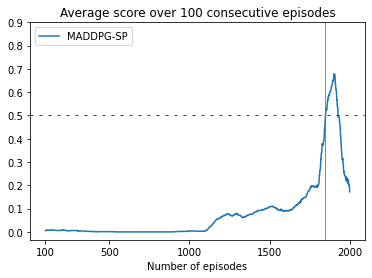

In [12]:
def plot_results(agents, training_results):
    for agent, ts in zip(agents, training_results):
        mean, std_dev, _ = ts
        episode_solved = np.argmax(mean > 0.5) + 100
        print('{}: Solved after {} episodes'.format(agent[0], episode_solved))

        x = np.arange(100, 100 + mean.size)
        line = plt.plot(x, mean, label = agent[0])
        plt.fill_between(x, mean + std_dev, mean - std_dev, alpha=0.25)
        plt.axvline(episode_solved, lw=0.75, color=line[0].get_color())

    plt.axhline(0.5, dashes=(4, 8), lw=0.75, color='black')
    plt.xticks([100, 500, 1000, 1500, 2000])
    plt.yticks(np.arange(0, 10) / 10)
    plt.xlabel('Number of episodes')
    plt.title('Average score over 100 consecutive episodes')
    plt.legend()
    plt.show()

plot_results(agents, training_results)

## 8. Possible improvements

After observing many test runs fail and many others succeed, I believe that one way to improve the stability of this approach would be to better handle the noise in a way that prevents overfitting. In fact, while some runs showed an agent that overfit to the wrong behaviours (like going straight to the net, missing the ball entirely), in some cases this sort of overfitting happened to match good behaviours, like a swing motion. These were in fact the cases where the environment was solved. Therefore, I believe that tweaking the noise so that these kinds of motions happen prior to overfitting is crucial for having more consistent results. Perhaps a hard reset might be the most effective trick to prevent wasting too much time, since we can determine relatively quickly whether training is going in a good direction or not.

We could also apply some of the techniques seen in other approaches. For instance, we could use **n-steps** for more accurate estimations of the TD targets, providing a better mix between bias and variance, or use a **prioritized replay buffer** so that the agent mostly learns from its worst mistakes.

Finally, we could try a drastically different approach, such as one that does not use self play, but instead uses two distinct agents trained without modifications to MADDPG. Or perhaps we could simply rely on DDPG to train one agant that doesn't know it has an opponent. The point is, there is still a lot of room for exploration (_no pun intended_).

## 9. Conclusions

Although there are many more improvements that could be applied, with a little bit of patience we can obtain an agent that successfully completes the training process and reaches high scores. The models used to create the graphs in section 7 are available in the repository. The full documented code is also available and `main.py` can be executed to train or load a pre-trained a pair of MADDPG agents and see them in action, just like it was done to get the model `final.pht`.